# Analyses of the morphological profile embeddings
---
In this notebook we will provide some exploratory analyses of the imaging data using the morphological profiles at a single-cell level computed by the authors describing several morphometrical features and some spatial features for the U20S cells treated with different ORF constructs.

---

## 0. Environmental setup

In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import umap
import hdbscan
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import operator

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [150]:
def find_markers(data, labels):
    marker_results = {
        "label": [],
        "feature": [],
        "mean_diff": [],
        "abs_mean_diff": [],
        "pval": [],
    }
    for label in tqdm(
        np.unique(labels[labels >= 0]), desc="Screen for cluster markers"
    ):
        for feature in list(data.columns):
            if feature != "labels":
                feature_dist = np.array(data.loc[:, feature])
                feature_dist = (feature_dist - feature_dist.mean()) / feature_dist.std()
                x = feature_dist[labels == label]
                y = feature_dist[
                    np.array((labels != label) * (labels >= 0)).astype(bool)
                ]
                marker_results["label"].append(label)
                marker_results["feature"].append(feature)
                marker_results["mean_diff"].append(np.mean(x) - np.mean(y))
                marker_results["abs_mean_diff"].append(
                    np.abs(marker_results["mean_diff"][-1])
                )
                marker_results["pval"].append(mannwhitneyu(x, y)[1])
    marker_results["fdr"] = fdrcorrection(np.array(marker_results["pval"]))[1]
    return pd.DataFrame(marker_results)

<IPython.core.display.Javascript object>

In [ ]:
def

---

## 1. Read in data

In [37]:
morph_embs = pd.read_csv(
    "../../data/images/metadata/nuclei_profiles_hoechst_cleaned.csv", index_col=0
)

<IPython.core.display.Javascript object>

After loading the data, we will quickly remove a number of features that are identifier rather than morphometrical features as we do not want to our analyses to be confounded by the inclusion of these.

In [40]:
exclude_features = [
    "ImageNumber",
    "Nuclei_AreaShape_Center_X",
    "Nuclei_AreaShape_Center_Y",
    "Nuclei_Location_CenterMassIntensity_X_Hoechst",
    "Nuclei_Location_CenterMassIntensity_Y_Hoechst",
    "Nuclei_Location_Center_X",
    "Nuclei_Location_Center_Y",
    "Nuclei_Location_MaxIntensity_X_Hoechst",
    "Nuclei_Location_MaxIntensity_X_Hoechst",
    "Nuclei_Neighbors_FirstClosestObjectNumber_1",
    "Nuclei_Neighbors_SecondClosestObjectNumber_1",
    "Nuclei_AreaShape_Orientation",
]

<IPython.core.display.Javascript object>

In [41]:
morph_embs = morph_embs.drop(exclude_features, axis=1)

<IPython.core.display.Javascript object>

In [42]:
features = np.array(morph_embs.iloc[:, :-1])
labels = np.array(morph_embs.iloc[:, -1])

<IPython.core.display.Javascript object>

---

## 2. UMAP embedding

In [43]:
scaled_features = StandardScaler().fit_transform(features)

<IPython.core.display.Javascript object>

In [58]:
umapper = umap.UMAP(random_state=1234, min_dist=0.0).fit(scaled_features)

<IPython.core.display.Javascript object>

In [59]:
umap_embs = umapper.transform(scaled_features)

<IPython.core.display.Javascript object>

In [1]:
plt.figure(figsize=[12, 8])
plt.scatter(
    umap_embs[:, 0],
    umap_embs[:, 1],
    alpha=0.1,
    s=2,
    c="tab:gray",
)
plt.xlabel("umap-c1")
plt.ylabel("umap-c2")
plt.title("Umap embedding of the morphological profiles")
plt.show()

NameError: name 'plt' is not defined

---

## 3. Clustering of the nuclei

We now aim to describe the observed heterogeneity in the cell populations using two clustering approaches.
First, a density-based clustering approach us HDBSCAN applied to the UMAP embeddings and b) a graph-based clustering approach using PCA embeddings of the scaled input data.

### 3a. Density-based clustering using HDBSCAN

We define the hyperparameters for the HDBSCAN algorithm such that the minimum size of the identified clusters is 500, i.e. each cluster consists of at least 500 cells.

In [89]:
hdbscan_labels = hdbscan.HDBSCAN(
    min_samples=None,
    min_cluster_size=500,
).fit_predict(umap_embs)

<IPython.core.display.Javascript object>

Below we plot the cluster assignments but excluding all points that were identified as noise by the algorithm.

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


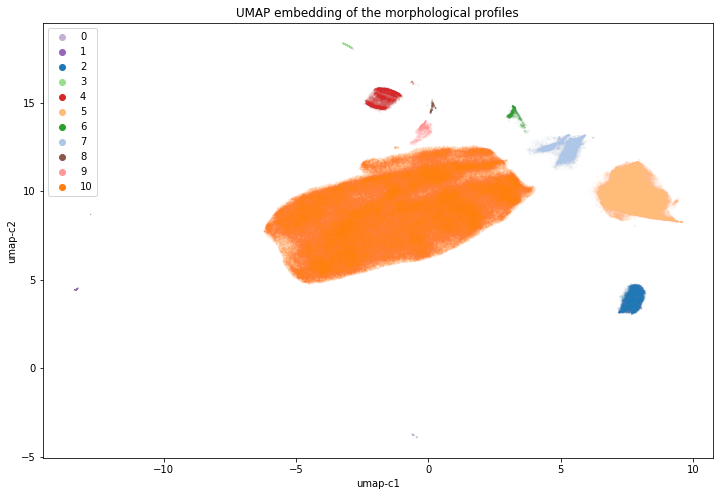

<IPython.core.display.Javascript object>

In [187]:
plt.figure(figsize=[12, 8])
ax = sns.scatterplot(
    umap_embs[hdbscan_labels >= 0, 0],
    umap_embs[hdbscan_labels >= 0, 1],
    alpha=0.05,
    s=2,
    hue=hdbscan_labels[hdbscan_labels >= 0].astype(str),
    palette="tab20",
)
handles, labels = ax.get_legend_handles_labels()
hl = sorted(
    zip(handles, list(np.array(labels).astype(int))), key=operator.itemgetter(1)
)
handles2, labels2 = zip(*hl)
ax.legend(handles2, labels2)
plt.xlabel("umap-c1")
plt.ylabel("umap-c2")
plt.title("UMAP embedding of the morphological profiles")
plt.show()

In [151]:
hdbscan_cluster_marker = find_markers(data=morph_embs, labels=hdbscan_labels)

Screen for cluster markers: 100%|██████████| 11/11 [03:08<00:00, 17.10s/it]


<IPython.core.display.Javascript object>

We will now characterize by running a Wilcoxon-rank sum-based test screen over the set of morphological features comparing the population of each cell cluster against all other clustered cells.

In [152]:
significant_hdbscan_cluster_marker = hdbscan_cluster_marker.loc[
    hdbscan_cluster_marker["fdr"] < 1e-5
]

<IPython.core.display.Javascript object>

We select a cutoff for the FDR of 1e-5 and now show the 10 features with largest absolute mean difference after z-transforming the data for each cluster.

In [170]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 0
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
3,0,Nuclei_AreaShape_EulerNumber,-23.092030,23.092030,0.000000e+00,0.000000e+00
5,0,Nuclei_AreaShape_FormFactor,-2.435242,2.435242,0.000000e+00,0.000000e+00
14,0,Nuclei_AreaShape_Solidity,-1.278755,1.278755,1.488564e-191,3.840105e-191
13,0,Nuclei_AreaShape_Perimeter,1.105109,1.105109,2.453598e-160,5.960595e-160
65,0,Nuclei_Intensity_LowerQuartileIntensity_Hoechst,-0.949261,0.949261,3.683060e-224,1.008806e-223
115,0,Nuclei_Texture_SumAverage_Hoechst_5_0,-0.934120,0.934120,7.235441e-148,1.712346e-147
108,0,Nuclei_Texture_InfoMeas2_Hoechst_3_0,-0.883216,0.883216,8.141865e-140,1.900690e-139
54,0,Nuclei_Granularity_1_Hoechst,0.864727,0.864727,9.875308e-184,2.496057e-183
114,0,Nuclei_Texture_SumAverage_Hoechst_3_0,-0.837460,0.837460,2.365120e-119,5.228360e-119
102,0,Nuclei_Texture_Gabor_Hoechst_3,0.796337,0.796337,1.195093e-97,2.434448e-97


<IPython.core.display.Javascript object>

The nuclei in cluster 0 seem to be less convex and more elongated compared to the cells in the other clusters.

In [171]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 1
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
241,1,Nuclei_Texture_SumEntropy_Hoechst_10_0,-13.874804,13.874804,0.000000e+00,0.000000e+00
223,1,Nuclei_Texture_Entropy_Hoechst_10_0,-13.586635,13.586635,0.000000e+00,0.000000e+00
217,1,Nuclei_Texture_DifferenceEntropy_Hoechst_10_0,-11.332217,11.332217,0.000000e+00,0.000000e+00
228,1,Nuclei_Texture_Gabor_Hoechst_5,10.965770,10.965770,0.000000e+00,0.000000e+00
238,1,Nuclei_Texture_SumAverage_Hoechst_10_0,-9.461486,9.461486,0.000000e+00,0.000000e+00
227,1,Nuclei_Texture_Gabor_Hoechst_3,8.088261,8.088261,0.000000e+00,0.000000e+00
212,1,Nuclei_Texture_Contrast_Hoechst_3_0,5.901297,5.901297,2.197067e-221,6.005900e-221
231,1,Nuclei_Texture_InfoMeas1_Hoechst_5_0,-5.578829,5.578829,0.000000e+00,0.000000e+00
179,1,Nuclei_Granularity_1_Hoechst,5.351890,5.351890,6.751205e-217,1.827344e-216
226,1,Nuclei_Texture_Gabor_Hoechst_10,5.247018,5.247018,0.000000e+00,0.000000e+00


<IPython.core.display.Javascript object>

The nuclei in cluster 1 mostly differ with respect to the other clusters in terms of texture. They seem to feature very high contrast and regular patterns with respect to their chromatin organzation.

In [172]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 2
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
331,2,Nuclei_Neighbors_PercentTouching_1,-4.496285,4.496285,0.000000e+00,0.000000e+00
332,2,Nuclei_Neighbors_SecondClosestDistance_1,-1.288490,1.288490,0.000000e+00,0.000000e+00
329,2,Nuclei_Neighbors_FirstClosestDistance_1,-1.100792,1.100792,0.000000e+00,0.000000e+00
260,2,Nuclei_AreaShape_MedianRadius,0.289942,0.289942,0.000000e+00,0.000000e+00
351,2,Nuclei_Texture_Gabor_Hoechst_10,-0.285634,0.285634,1.676535e-247,4.822669e-247
354,2,Nuclei_Texture_InfoMeas1_Hoechst_10_0,0.284051,0.284051,3.793497e-276,1.133926e-275
259,2,Nuclei_AreaShape_MeanRadius,0.282129,0.282129,3.749125e-306,1.155840e-305
357,2,Nuclei_Texture_InfoMeas2_Hoechst_10_0,-0.278648,0.278648,1.021553e-260,2.988585e-260
256,2,Nuclei_AreaShape_MajorAxisLength,0.274349,0.274349,5.755325e-278,1.727854e-277
263,2,Nuclei_AreaShape_Perimeter,0.269914,0.269914,2.143234e-258,6.230330e-258


<IPython.core.display.Javascript object>

The nuclei in cluster 2 differ most signficantly from the other nuclei with respect to their proximity to other nuclei in the same plate suggesting they correspond to those from less populated regions potentially correlating with experimental setups leading to cell death.

In [173]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 3
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
449,3,Nuclei_Intensity_StdIntensityEdge_Hoechst,19.856865,19.856865,0.0,0.0
442,3,Nuclei_Intensity_MaxIntensityEdge_Hoechst,19.724551,19.724551,0.0,0.0
444,3,Nuclei_Intensity_MeanIntensityEdge_Hoechst,18.431549,18.431549,0.0,0.0
438,3,Nuclei_Intensity_IntegratedIntensityEdge_Hoechst,18.206127,18.206127,0.0,0.0
445,3,Nuclei_Intensity_MeanIntensity_Hoechst,16.274186,16.274186,0.0,0.0
451,3,Nuclei_Intensity_UpperQuartileIntensity_Hoechst,16.137298,16.137298,0.0,0.0
446,3,Nuclei_Intensity_MedianIntensity_Hoechst,16.001949,16.001949,0.0,0.0
450,3,Nuclei_Intensity_StdIntensity_Hoechst,14.880058,14.880058,0.0,0.0
443,3,Nuclei_Intensity_MaxIntensity_Hoechst,14.033129,14.033129,0.0,0.0
439,3,Nuclei_Intensity_IntegratedIntensity_Hoechst,11.274226,11.274226,0.0,0.0


<IPython.core.display.Javascript object>

The nuclei in cluster 3 are vastly different in terms of their overall intensity levels suggesting higher chromatin compaction levels but also larger variance in those.

In [174]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 4
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
581,4,Nuclei_Neighbors_PercentTouching_1,-3.154774,3.154774,0.000000e+00,0.000000e+00
580,4,Nuclei_Neighbors_NumberOfNeighbors_1,2.789850,2.789850,0.000000e+00,0.000000e+00
582,4,Nuclei_Neighbors_SecondClosestDistance_1,1.781214,1.781214,0.000000e+00,0.000000e+00
579,4,Nuclei_Neighbors_FirstClosestDistance_1,1.581945,1.581945,0.000000e+00,0.000000e+00
578,4,Nuclei_Neighbors_AngleBetweenNeighbors_1,-0.596345,0.596345,0.000000e+00,0.000000e+00
577,4,Nuclei_Location_MaxIntensity_Y_Hoechst,-0.401851,0.401851,0.000000e+00,0.000000e+00
607,4,Nuclei_Texture_InfoMeas2_Hoechst_10_0,-0.282648,0.282648,5.984583e-234,1.672521e-233
510,4,Nuclei_AreaShape_MedianRadius,0.277463,0.277463,2.871044e-231,7.975123e-231
604,4,Nuclei_Texture_InfoMeas1_Hoechst_10_0,0.275838,0.275838,1.296158e-225,3.557320e-225
506,4,Nuclei_AreaShape_MajorAxisLength,0.274523,0.274523,1.996881e-228,5.502428e-228


<IPython.core.display.Javascript object>

The nuclei in cluster 4 again are most different from the other clusters with respect to their local neighborhood. The metrics suggest that these nuclei are also farer apart from their closest neighbors in general than those in the other clusters, but at the same time have more neighboring cells in general. Thus, this is unlikely to stem from a toxic interaction as seen for cluster 2.

In [175]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 5
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
635,5,Nuclei_AreaShape_MedianRadius,-1.765654,1.765654,0.0,0.0
631,5,Nuclei_AreaShape_MajorAxisLength,-1.733018,1.733018,0.0,0.0
638,5,Nuclei_AreaShape_Perimeter,-1.726979,1.726979,0.0,0.0
634,5,Nuclei_AreaShape_MeanRadius,-1.718328,1.718328,0.0,0.0
632,5,Nuclei_AreaShape_MaxFeretDiameter,-1.674221,1.674221,0.0,0.0
625,5,Nuclei_AreaShape_Area,-1.635574,1.635574,0.0,0.0
732,5,Nuclei_Texture_InfoMeas2_Hoechst_10_0,1.574990,1.574990,0.0,0.0
729,5,Nuclei_Texture_InfoMeas1_Hoechst_10_0,-1.548514,1.548514,0.0,0.0
633,5,Nuclei_AreaShape_MaximumRadius,-1.527241,1.527241,0.0,0.0
636,5,Nuclei_AreaShape_MinFeretDiameter,-1.439822,1.439822,0.0,0.0


<IPython.core.display.Javascript object>

The cells in cluster 5 correspond to those with smaller nuclei compared to the rest.

In [176]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 6
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
834,6,Nuclei_Texture_AngularSecondMoment_Hoechst_3_0,7.391785,7.391785,0.0,0.0
835,6,Nuclei_Texture_AngularSecondMoment_Hoechst_5_0,6.951179,6.951179,0.0,0.0
865,6,Nuclei_Texture_SumAverage_Hoechst_5_0,-5.560647,5.560647,0.0,0.0
849,6,Nuclei_Texture_Entropy_Hoechst_3_0,-5.552805,5.552805,0.0,0.0
864,6,Nuclei_Texture_SumAverage_Hoechst_3_0,-5.456174,5.456174,0.0,0.0
850,6,Nuclei_Texture_Entropy_Hoechst_5_0,-5.188357,5.188357,0.0,0.0
867,6,Nuclei_Texture_SumEntropy_Hoechst_3_0,-4.906397,4.906397,0.0,0.0
863,6,Nuclei_Texture_SumAverage_Hoechst_10_0,-4.627567,4.627567,0.0,0.0
816,6,Nuclei_Intensity_MassDisplacement_Hoechst,4.427640,4.427640,0.0,0.0
868,6,Nuclei_Texture_SumEntropy_Hoechst_5_0,-4.261262,4.261262,0.0,0.0


<IPython.core.display.Javascript object>

Cluster 6 describes cells with smoother texture and thus very homogenous compaction of the chromatin.

In [177]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 7
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
950,7,Nuclei_Intensity_StdIntensity_Hoechst,3.528856,3.528856,0.0,0.0
943,7,Nuclei_Intensity_MaxIntensity_Hoechst,3.421479,3.421479,0.0,0.0
930,7,Nuclei_Granularity_2_Hoechst,3.302081,3.302081,0.0,0.0
999,7,Nuclei_Texture_Variance_Hoechst_5_0,3.091014,3.091014,0.0,0.0
951,7,Nuclei_Intensity_UpperQuartileIntensity_Hoechst,3.047712,3.047712,0.0,0.0
998,7,Nuclei_Texture_Variance_Hoechst_3_0,2.994888,2.994888,0.0,0.0
995,7,Nuclei_Texture_SumVariance_Hoechst_3_0,2.731602,2.731602,0.0,0.0
976,7,Nuclei_Texture_Gabor_Hoechst_10,2.726823,2.726823,0.0,0.0
945,7,Nuclei_Intensity_MeanIntensity_Hoechst,2.722310,2.722310,0.0,0.0
963,7,Nuclei_Texture_Contrast_Hoechst_5_0,2.600352,2.600352,0.0,0.0


<IPython.core.display.Javascript object>

Cluster 7 describes cells that show higher levels of chromatin compaction and more granular structures compared to the rest.

In [178]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 8
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
1060,8,Nuclei_Granularity_7_Hoechst,15.671047,15.671047,5.605815e-235,1.582751e-234
1061,8,Nuclei_Granularity_8_Hoechst,11.785515,11.785515,1.761323e-303,5.417938e-303
1062,8,Nuclei_Granularity_9_Hoechst,7.200993,7.200993,0.000000e+00,0.000000e+00
1047,8,Nuclei_Granularity_10_Hoechst,4.980938,4.980938,0.000000e+00,0.000000e+00
1048,8,Nuclei_Granularity_11_Hoechst,3.799626,3.799626,0.000000e+00,0.000000e+00
1049,8,Nuclei_Granularity_12_Hoechst,3.149582,3.149582,4.212220e-212,1.129006e-211
1000,8,Nuclei_AreaShape_Area,2.781314,2.781314,3.219463e-91,6.424907e-91
1011,8,Nuclei_AreaShape_MinFeretDiameter,2.135427,2.135427,8.872509e-113,1.900265e-112
1013,8,Nuclei_AreaShape_Perimeter,2.111093,2.111093,5.066316e-117,1.114590e-116
1012,8,Nuclei_AreaShape_MinorAxisLength,2.100811,2.100811,1.649518e-109,3.478661e-109


<IPython.core.display.Javascript object>

Cluster 8 seems to describe larger nuclei with highly granular chromatin structures.

In [179]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 9
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
1184,9,Nuclei_Granularity_6_Hoechst,10.985413,10.985413,0.0,0.0
1185,9,Nuclei_Granularity_7_Hoechst,3.964798,3.964798,0.0,0.0
1125,9,Nuclei_AreaShape_Area,3.012298,3.012298,0.0,0.0
1137,9,Nuclei_AreaShape_MinorAxisLength,2.739355,2.739355,0.0,0.0
1136,9,Nuclei_AreaShape_MinFeretDiameter,2.733480,2.733480,0.0,0.0
1133,9,Nuclei_AreaShape_MaximumRadius,2.580731,2.580731,0.0,0.0
1134,9,Nuclei_AreaShape_MeanRadius,2.468163,2.468163,0.0,0.0
1135,9,Nuclei_AreaShape_MedianRadius,2.374928,2.374928,0.0,0.0
1138,9,Nuclei_AreaShape_Perimeter,2.310955,2.310955,0.0,0.0
1189,9,Nuclei_Intensity_IntegratedIntensity_Hoechst,2.180424,2.180424,0.0,0.0


<IPython.core.display.Javascript object>

Cluster 9 shows very similar characteristics as cluster 8 in general, suggesting those cells might actually cluster together.

In [189]:
significant_hdbscan_cluster_marker.loc[
    significant_hdbscan_cluster_marker["label"] == 10
].sort_values("abs_mean_diff", ascending=False).head(10)

,label,feature,mean_diff,abs_mean_diff,pval,fdr
1256,10,Nuclei_AreaShape_MajorAxisLength,1.286389,1.286389,0.0,0.0
1260,10,Nuclei_AreaShape_MedianRadius,1.282924,1.282924,0.0,0.0
1263,10,Nuclei_AreaShape_Perimeter,1.254532,1.254532,0.0,0.0
1257,10,Nuclei_AreaShape_MaxFeretDiameter,1.247168,1.247168,0.0,0.0
1259,10,Nuclei_AreaShape_MeanRadius,1.244614,1.244614,0.0,0.0
1357,10,Nuclei_Texture_InfoMeas2_Hoechst_10_0,-1.194668,1.194668,0.0,0.0
1354,10,Nuclei_Texture_InfoMeas1_Hoechst_10_0,1.186394,1.186394,0.0,0.0
1351,10,Nuclei_Texture_Gabor_Hoechst_10,-1.168371,1.168371,0.0,0.0
1250,10,Nuclei_AreaShape_Area,1.162235,1.162235,0.0,0.0
1258,10,Nuclei_AreaShape_MaximumRadius,1.095361,1.095361,0.0,0.0


<IPython.core.display.Javascript object>

The largest cluster 10 shows slightly enlarged nuclei that are more circular show smoother texture.